# Working with Namespaces in Pinecone

Namespaces are a unique concept in Pinecone -- they are logical separators of vectors within a single index. Namespaces are invaluable when tackling problems surrounding multitenancy and scaling in a financially sustainable manner. Stay tuned for an indepth writeup about namespaces that will touch on these issues and much more in the future.

For now, we will showcase namespaces' utility when dealing with a simple multitenant situation.

## The Setup

For this demo, we will be working with three Wikipedia datasets [from HuggingFace](https://huggingface.co/datasets/wikipedia); one in English, one in French, and one in Italian. Each dataset contains `id`, `url`, `title`, and `text` columns. We will direct tenants' queries to the appropriate namespace based on the language they pass in at query-time.

First, let's create some tenants & their queries for our scenario:

In [607]:
tenants_en = [{"name": "Audrey",
              "preferred_language": "en",
              "query": "What does the fox say?"},
              
               {"name": "Jared",
               "pref_language": "en",
               "query": "Why does the brown fox jump over the lazy dog?"}
             ]

tenants_fr = [{"name": "Michel",
              "preferred_language": "fr",
              "query": "Pourquoi la lune brille?"},
              
               {"name": "Antoine",
               "pref_language": "fr",
               "query": "Quel est le meilleur fromage?"}
             ]

tenants_it = [{"name": "Francesca",
              "preferred_language": "it",
              "query": "Cos'è il mediterraneo??"},
              
               {"name": "Emilio",
               "pref_language": "it",
               "query": "Quale romano era il più forte?"}
             ]

## Initialize our Pinecone Index

We will create a Pinecone index that stores `1536`-dimension vectors and uses cosine similarity as its similarity metric (see [here](https://docs.pinecone.io/docs/choosing-index-type-and-size) for more about dimensions & [here](https://www.pinecone.io/learn/vector-similarity/) for more about similarity metrics). We will be using OpenAI's [text-embedding-ada-002](https://openai.com/blog/new-and-improved-embedding-model) model to produce embeddings of our textual data, and since that model outputs `1536`-dimension vectors, that's what our index will have to be configured for.

To keep things straightforward, we will name our index `"namespaces-demo"`.


In [5]:
# !pip3 install langchain

>**Note:** If you run into this Protobuf issue when importing Pinecone, simply run `!pip3 install --force-reinstall -v protobuf==3.20`, restart the notebook's kernel, and re-import pinecone.

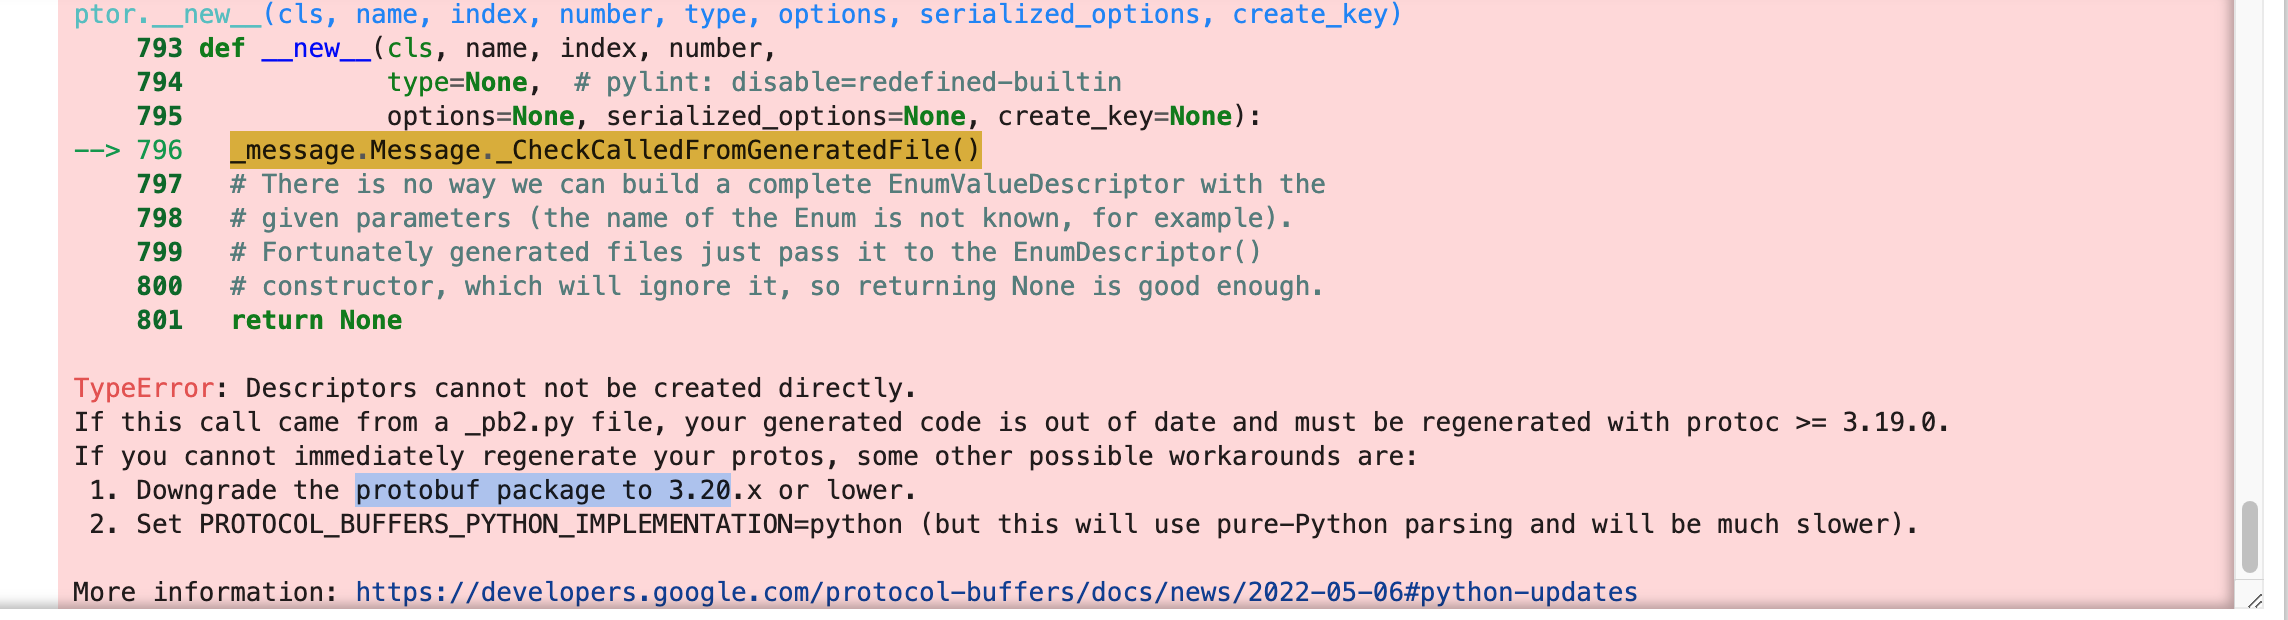

In [12]:
# !pip3 uninstall protobuf

# !pip3 install --force-reinstall -v protobuf==3.20

In [727]:
# Note: This step takes a little while to complete, so don't worry if it takes 30s or so!

from getpass import getpass
from langchain.embeddings.openai import OpenAIEmbeddings
import pinecone

# Find API key in console at app.pinecone.io
YOUR_API_KEY = getpass("Pinecone API Key: ")

# Find ENV (cloud region) next to API key in console
YOUR_ENV = input("Pinecone environment: ")

INDEX_NAME = 'namespaces-demo'

# Initialize Pinecone client
pinecone.init(
    api_key=YOUR_API_KEY,
    environment=YOUR_ENV
)

# Create index
pinecone.create_index(
    name=INDEX_NAME,
    metric='cosine',
    dimension=1536)

Pinecone API Key:  ········
Pinecone environment:  us-east-1-aws



To connect to the index we just created, we will use the [GRPCIndex class](https://github.com/pinecone-io/pinecone-python-client/blob/main/pinecone/core/grpc/index_grpc.py#L293) (this class is generally quicker than the [REST Index class](https://github.com/pinecone-io/pinecone-python-client/blob/main/pinecone/index.py#L49) when you've got a lot of data to process). 

You can see below with the `.describe_index_stats()` method that our index currently has `0` vectors in it (`'total_vector_count': 0`).

In [728]:
demo_index = pinecone.GRPCIndex(INDEX_NAME)

demo_index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

## Prepare Our Data

Since our dataset is not yet vectorized, let's vectorize it using [Langchain](https://docs.langchain.com/docs/). 

We will use OpenAI's [text-embedding-ada-002](https://openai.com/blog/new-and-improved-embedding-model) model to produce embeddings of our textual data. We will then upsert (aka "index") these embeddings into our Pinecone index.

Using Langchain, we can chunk up our text data, extract metadata, and create embeddings easily. 

### Load & preview

The data we'll be using is Wikipedia data in 3 different languages: English, French, and Italian. The datasets are from [HuggingFace](https://huggingface.co/datasets/wikipedia). Since they take a pretty long time to load in their entirety, we'll be using snippets. You can download them locally < here >. 

If you want to load the datasets in their entirety, you can execute this code

```
from datasets import load_dataset

wiki_en = load_dataset("wikipedia", "20220301.en")
wiki_it = load_dataset("wikipedia", "20220301.it")
wiki_fr = load_dataset("wikipedia", "20220301.fr")
```

To preview the datasets, you'll want to drill down to the `train` section, like so (you can read more about the various methods available to run on HuggingFace's `DatasetDict` objects [here](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.DatasetDict)): 

```
wiki_en['train'][:1000]
```

In [729]:
# todo: pull in data like this

from datasets import load_dataset
wiki_en = load_dataset("wikipedia", "20220301.en", split="train[:10]")

In [730]:
# Preview data in Pandas dataframe
wiki_en.to_pandas()

,id,url,title,text
0,12,https://en.wikipedia.org/wiki/Anarchism,Anarchism,Anarchism is a political philosophy and moveme...
1,25,https://en.wikipedia.org/wiki/Autism,Autism,Autism is a neurodevelopmental disorder charac...
2,39,https://en.wikipedia.org/wiki/Albedo,Albedo,Albedo (; ) is the measure of the diffuse refl...
3,290,https://en.wikipedia.org/wiki/A,A,"A, or a, is the first letter and the first vow..."
4,303,https://en.wikipedia.org/wiki/Alabama,Alabama,Alabama () is a state in the Southeastern regi...
5,305,https://en.wikipedia.org/wiki/Achilles,Achilles,"In Greek mythology, Achilles ( ) or Achilleus ..."
6,307,https://en.wikipedia.org/wiki/Abraham%20Lincoln,Abraham Lincoln,"Abraham Lincoln (; February 12, 1809 – April 1..."
7,308,https://en.wikipedia.org/wiki/Aristotle,Aristotle,"Aristotle (; Aristotélēs, ; 384–322 BC) was a..."
8,309,https://en.wikipedia.org/wiki/An%20American%20...,An American in Paris,An American in Paris is a jazz-influenced orch...
9,316,https://en.wikipedia.org/wiki/Academy%20Award%...,Academy Award for Best Production Design,The Academy Award for Best Production Design r...


In [577]:
# Load in dataset snippets from CSV files as Pandas dataframes
# import pandas as pd

# wiki_en = pd.read_csv('wiki_en.csv', index_col='Unnamed: 0')
# wiki_fr = pd.read_csv('wiki_fr.csv', index_col='Unnamed: 0')
# wiki_it = pd.read_csv('wiki_it.csv', index_col='Unnamed: 0')

In [731]:
# Preview
# wiki_en.head()

In [732]:
# Preview
# wiki_fr.head()

In [733]:
# Preview
# wiki_it.head()

### Chunk, Extract metadata, and Create embeddings

As noted before, in order to get our data into our Pinecone index (`"namespaces-demo"`), we'll need to chunk it all up, figure out what (if any) metadata we want to include, and then transform it into embeddings.

You can read more about chunking [here](https://www.pinecone.io/learn/chunking-strategies/) and metadata [here](https://docs.pinecone.io/docs/metadata-filtering).

**Note:** You will need an [OpenAI](https://openai.com/) API Key for the next part, since we will be making API calls to an OpenAI-hosted model: `ada-002`

In [734]:
# Initialize our OpenAI model we'll use to create our embeddings

from getpass import getpass
from langchain.embeddings.openai import OpenAIEmbeddings

OPENAI_API_KEY = getpass("OpenAI API Key: ")
model_name = 'text-embedding-ada-002'

embed = OpenAIEmbeddings(
    model=model_name,
    openai_api_key=OPENAI_API_KEY
)

OpenAI API Key:  ········


In [39]:
# !pip3 install tiktoken

In [735]:
import tiktoken

tiktoken.encoding_for_model('text-embedding-ada-002')

tokenizer = tiktoken.get_encoding('cl100k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

In [736]:
# Define a function that'll split up our dataset's text
# Documentation for reference: https://python.langchain.com/docs/modules/data_connection/document_transformers/

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema.document import Document

def chunk_by_size(text: str, size: int = 50) -> list[Document]:
    """
    Chunk up text recursively by character.
    
    :param text: Text to be chunked up
    :return: List of Document items representing n chunks.
    """
    text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = size,
    chunk_overlap = 20,
    length_function = tiktoken_len,
    add_start_index = True,
)

    return text_splitter.create_documents([text])

In [739]:
wiki_en.to_pandas().head(2)

,id,url,title,text
0,12,https://en.wikipedia.org/wiki/Anarchism,Anarchism,Anarchism is a political philosophy and moveme...
1,25,https://en.wikipedia.org/wiki/Autism,Autism,Autism is a neurodevelopmental disorder charac...


In [740]:
from tqdm.auto import tqdm
from uuid import uuid4

In [741]:
def create_chunks(dataset: pd.DataFrame):
    """

    :param dataset: Data we want in our Pinecone index.
    """
    test_output = []
    
    for index, row in tqdm(dataset.iterrows()):  # (tqdm library prints status of for-loop to console)        
        # chunk up the row of text
        chunked_text = chunk_by_size(row["text"])
        
        # extract just the string content from the chunk
        chunked_text = [c.page_content for c in chunked_text]

        for idx, text in enumerate(chunked_text):
            payload = {
                "metadata": {
                    "URL": row["url"],
                    "Title": row["title"],
                    "chunk_num": idx, 
                    "text_content": text
                },
             "id": str(uuid4()),
            "values": embed.embed_documents(text)[0]
            }
            test_output.append(payload)

    return test_output
            
            


#### Let's chunk up the first 2 rows of our datasets for the example

(Don't worry if this part takes a few minutes to run -- Wikipedia articles (even just 2) are *long* and creating embeddings is a lot of work!)

#### English

In [742]:
# English
chunks_2_en = create_chunks(wiki_en.to_pandas().head(2))

2it [08:03, 241.70s/it]


In [749]:
# Preview
chunks_2_en[570]

{'metadata': {'URL': 'https://en.wikipedia.org/wiki/Autism',
  'Title': 'Autism',
  'chunk_num': 291,
  'text_content': 'is distinct from fringe theories that autism is caused by environmental factors such as vaccines. A common criticism against autistic activists is that the majority of them are "high-functioning" or have Asperger syndrome and do not represent the views of'},
 'id': 'f6cf5654-107c-42e4-926d-2dd939e3d7e7',
 'values': [-0.01162897945371462,
  -0.024939921971402934,
  -0.005142394238800282,
  -0.022582416594355205,
  -0.0291999741749962,
  0.027504225673599714,
  -0.02277542948208146,
  -0.025836049909694053,
  -0.006059201730209518,
  -0.017881193140327774,
  0.019797527266941343,
  0.023726702895354227,
  -0.0038464555532951696,
  -0.00214553634871186,
  -0.005842062930009446,
  0.01380036559307011,
  0.022279112756665647,
  0.008609719063660886,
  -0.001981820775138208,
  -0.008740690963726235,
  -0.016020004488695855,
  0.004945935457379638,
  -0.016778266876887608,


In [590]:
# Our two rows of Wikipedia data have resulted in 578 "chunks", each with metadata, an ID, and a vector representation of 
# part of the article text
len(chunks_2_en)

578

#### Italian

In [587]:
# Italian:
chunks_2_it = create_chunks(wiki_it.head(2))

2it [02:48, 84.18s/it]


In [588]:
# Preview
chunks_2_it[0]

{'metadata': {'URL': 'https://it.wikipedia.org/wiki/Organo%20a%20pompa',
  'Title': 'Organo a pompa',
  'chunk_num': 0},
 'id': '7f1ad39e-b976-419e-bec3-3fc8a98899ad',
 'values': [0.013391470825516288,
  0.010053758027173045,
  0.00717641984145832,
  -0.00911946923497574,
  -0.025022686190095227,
  0.005179208920551007,
  -0.013046189516798949,
  0.0017450210034079166,
  -0.00668557980623042,
  -0.02070329425261871,
  0.016289119758625195,
  0.021989633205680953,
  0.00351712277051078,
  -0.0019142761839549406,
  -0.02667461766493026,
  0.0014759052302494005,
  0.03829229439389147,
  0.0075352411827771856,
  0.03826521153472083,
  -0.029788913638921274,
  -0.02356032169093925,
  -0.009227793221078057,
  -0.008002385113214572,
  -0.015909987669912147,
  0.0016553157844935167,
  -0.0013464249723110304,
  0.015937068666437727,
  -0.008604934026279855,
  0.015246506980325576,
  -0.01761607927515328,
  0.028922327338037918,
  -0.023424918570956414,
  -0.019173228193471316,
  -0.028272387146

In [591]:
len(chunks_2_it)

252

#### French

In [589]:
# french:
chunks_2_fr = create_chunks(wiki_fr.head(2))

2it [01:50, 55.49s/it]


In [ ]:
# Preview
chunks_2_fr[0]

In [592]:
len(chunks_2_fr)

170

## Upsert our Data into our Index, per Namespace

Now that we have chunked up our datasets into 'documents' comprised of metadata, an ID, and a vector representation of Wikipedia text, we need to put that into our `demo_index` index.

Since we want to sub-divide our index into namespaces, you'll see below that each time we call the `.upsert()` method, we also specify a `namespace` parameter. For our example, each namespace corresponds to the language of the dataset. 

We will index our data into our index in small batches of `100`. Read more about batch-indexing [here](#https://docs.pinecone.io/docs/insert-data#batching-upserts).

In [750]:
BATCH_SIZE = 100

def batch_upsert(data, index, namespace):
    """
    """
    for i in range(0, len(data), BATCH_SIZE):
        batch = data[i:i+BATCH_SIZE]
        index.upsert(vectors=batch, namespace=namespace)


# NOTE:
# - In Production, you'll want to have a try/except loop here to catch upsert errors.
# - You'll also likely want to optimize your batching as you scale your data. Parallelization and using generator objects will 
#   significantly improve your batch performance.
# - Last, you'll want to confirm that the # of vectors you upsert matches the # of vectors you intend to upsert.

    

#### English

In [752]:
# English
batch_upsert(chunks_2_en, demo_index, 'en')

In [753]:
# Confirm there are 578 vectors added to our index in the 'en' namespace
demo_index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'en': {'vector_count': 578}},
 'total_vector_count': 578}

In [649]:
# demo_index.delete(delete_all=True, namespace='en')


#### Italian

In [603]:
# Italian
batch_upsert(chunks_2_it, demo_index, 'it')

In [604]:
# Confirm there are 252 vectors added to our index in the 'it' namespace
demo_index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.1,
 'namespaces': {'en': {'vector_count': 578}, 'it': {'vector_count': 252}},
 'total_vector_count': 830}

#### French

In [605]:
# French
batch_upsert(chunks_2_fr, demo_index, 'fr')

In [606]:
# Confirm there are 170 vectors added to our index in the 'fr' namespace
demo_index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.1,
 'namespaces': {'en': {'vector_count': 578},
                'fr': {'vector_count': 170},
                'it': {'vector_count': 252}},
 'total_vector_count': 1000}

## Query Our Data

You'll remember one of the first things we did in this notebook was create different tenants, each with queries in a different language:
- tenants_en
- tenants_it
- tenants_fr

Using these tenants as examples, we will execute queries against different namespaces in our `demo_index` depending on the language passed in by each tenant

In [608]:
# Preview
tenants_en

[{'name': 'Audrey',
  'preferred_language': 'en',
  'query': 'What does the fox say?'},
 {'name': 'Jared',
  'pref_language': 'en',
  'query': 'Why does the brown fox jump over the lazy dog?'}]

Since we are dealing with vector space, we can't simply grab one of our English queries and execute it against our `demo_index` index. Instead, we first need to vectorize our query & send its *vector representation* to our `demo_index`.

In [754]:
# query = tenants_en[0].get('query')

# Let's ask about anarchism because we know one of our English articles is about that
query = 'What is anarchy?'
query_vector = embed.embed_query(query)

In [759]:
len(query_vector)

1536

In [762]:
namespace = tenants_en[0].get('preferred_language')
query_result = demo_index.query(vector=query_vector, top_k=5, include_metadata=True, namespace=namespace)

# Note you *must* include a namespace in your query now that we have subdivided our index into namespaces; otherwise, you will get 
# no results back.

In [763]:
query_result

{'matches': [{'id': 'ba395862-c6cb-4f7b-ad12-6c5084057acf',
              'metadata': {'Title': 'Autism',
                           'URL': 'https://en.wikipedia.org/wiki/Autism',
                           'chunk_num': 288.0,
                           'text_content': 'a result of natural variations in '
                                           'the human brain rather than a '
                                           'disorder to be cured. The autism '
                                           'rights movement advocates for '
                                           'including greater acceptance of '
                                           'autistic behaviors; therapies that '
                                           'focus on coping skills rather than '
                                           'on imitating the behaviors of '
                                           'those without autism, and the'},
              'score': 0.7790101,
              'sparse_values': {'in

## Filter by Metadata within a Single Namespace

In [636]:
demo_index.query(
    vector=query_vector,
    filter={
        "Title": {"$eq": "Anarchism"},
    },
    top_k=5,
    include_metadata=True,
    namespace='en'
)

{'matches': [{'id': 'cea55260-d749-4bd6-b1b8-ef7f8694704e',
              'metadata': {'Title': 'Anarchism',
                           'URL': 'https://en.wikipedia.org/wiki/Anarchism',
                           'chunk_num': 169.0},
              'score': 0.77158755,
              'sparse_values': {'indices': [], 'values': []},
              'values': []},
             {'id': '1f6c9387-66c7-4d60-bf17-e7232856c33f',
              'metadata': {'Title': 'Anarchism',
                           'URL': 'https://en.wikipedia.org/wiki/Anarchism',
                           'chunk_num': 193.0},
              'score': 0.7715746,
              'sparse_values': {'indices': [], 'values': []},
              'values': []},
             {'id': '0fe3f1d3-2cbc-4e3f-a1b0-463bf96772b1',
              'metadata': {'Title': 'Anarchism',
                           'URL': 'https://en.wikipedia.org/wiki/Anarchism',
                           'chunk_num': 141.0},
              'score': 0.7715746,
             

---

- Namespaces are like sub-indexes
- Namespaces are 1:1 with vectors, so you cannot search over 2+ namespaces at the same time
    - This also means that namespaces' vectors are mutually exclusive
- Namespaces are not available to users in the `gcp-whatever` runtime

- Touch on multitenancy wrt namespaces, e.g. Notion
    - Every index needs at least 1 pod, so there’s a cost incurred per index
    - partition == namespace
    - just add namespaces to an index — partition your index — serve more customers
        - don’t have to create more indices and pay more
        - searchers are limited to 1 namespace at a time
    - partitions are not literal (not data partition)
        - node ≠ partition! demystify!!!!
     

- Metadata filters

---

Install libs, fix SSL cert handshake issues, if you encounter them

In [ ]:
# !pip3 install pinecone-client

In [ ]:
# !pip3 install pinecone-datasets

In [ ]:
# !open /Applications/Python\ 3.11/Install\ Certificates.command

---

Start doin' shit

In [68]:
# !pip3 install datasets
# !pip3 install apache-beam

## Metadata filters within a single namespace